# Modelagem Elástica via Diferenças Finitas de Grade Escalonada

*   PET - Física UFRN
*   Petiano : Matheus Felipe Freitas Tomaz
*   Data : 15 de Março de 2024

No `Notebook` [Modelagam acústica via diferenças finitas](https://github.com/MathPhelip/PET.py/blob/main/Notebooks/Interpola%C3%A7%C3%A3o%20de%20um%20dado%20s%C3%ADsmico.ipynb) haviamos discutido sobre os ascpectos gerais da modelagem sísmica e apresentamos a física e a implementação computacional da modelagem acústica. Nesse material, haviamos discutidos que a modelo acústica apesar de muito usada, em alguns casos, como em dados do tipo OBN, não representa com exatidão o meio estudado, pois não leva em conta vários fatores importantes. A ideia desse Notebook é apresentar a outra cara da modelagem sísmica, conhecida como modelagem elástica, simulando uma propagação 2D via diferenças finitas.

Esse Notebook está divido nas sequintes seções :

*   **Introdução**
*   **Física da propagação elástica**
*   **Implementação computacional** 
*   **Conclusão**

## Pré - requisitos

É interessante que o leitor já tenha lido o material citado anteriormente para entender os aspectos gerais que envolve modelagem sísmica. Além de ter familiaridade com o método das diferenças finitas.

In [1]:
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib
import scipy as sp
import sympy as smp
import matplotlib.pyplot as plt
from scipy.misc import derivative
matplotlib.use("nbagg")
import matplotlib.pyplot as plt
from matplotlib import gridspec 
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

def opt_plot():
    plt.grid(True, linestyle = ':', color = '0.50')
    plt.rcParams['font.family'] = 'monospace'
    plt.rcParams['font.size'] = 15
    plt.minorticks_on()
    plt.tick_params(axis = 'both', which = 'minor', direction = "in",
                        top = True, right = True, length = 5, width = 1, labelsize = 15)
    plt.tick_params(axis = 'both', which = 'major', direction = "in",
                        top = True, right = True, length = 8, width = 1, labelsize = 15)
    
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext version_information
%version_information Matplotlib, Numpy, Scipy

Software versions
Python 3.9.2 64bit [MSC v.1928 64 bit (AMD64)]
IPython 7.25.0
OS Windows 10 10.0.19041 SP0
Matplotlib 3.4.2
Numpy 1.26.1
Scipy 1.11.3
Sun Mar 31 12:53:49 2024 Hora oficial do Brasil

## 1 . Introdução

****

A modelagem sísmica de ondas elásticas é uma técnica essencial na geofísica e na engenharia geotécnica, que emprega os princípios da física das ondas para estudar a propagação de ondas sísmicas através do subsolo. Ao contrário da modelagem de ondas acústicas, que considera apenas as variações na pressão do meio, a modelagem de ondas elásticas leva em conta também a deformação do material. Essa abordagem mais abrangente permite uma representação mais precisa das propriedades mecânicas do subsolo, sendo particularmente valiosa na exploração de recursos naturais, no planejamento de infraestrutura e na avaliação de riscos geotécnicos.

Na modelagem sísmica de ondas elásticas, as características físicas das rochas e dos fluidos presentes no subsolo são representadas em um modelo computacional, onde as ondas sísmicas são geradas e propagadas. Esses modelos permitem simular como diferentes tipos de ondas (como as ondas P e S) se comportam à medida que atravessam camadas de diferentes propriedades elásticas e estruturas geológicas. Os resultados dessas simulações fornecem insights valiosos sobre a subsuperfície da Terra, ajudando na identificação de reservatórios de petróleo e gás, na caracterização de aquíferos, na detecção de falhas geológicas e na avaliação de potenciais impactos sísmicos.

## 2. Física da modelagem elástica

****

A modelagem elástica está intrinsecamente ligada aos princípios fundamentais da física dos sólidos, que descrevem como os materiais se comportam quando submetidos a forças externas. A física subjacente à modelagem elástica é baseada nas leis da elasticidade, que governam a resposta dos materiais à aplicação de tensões e deformações. As leis da elasticidade descrevem como os materiais se deformam quando submetidos a forças externas. Isso inclui o conceito de elasticidade linear, onde a deformação é diretamente proporcional à tensão aplicada, conforme descrito pela lei de Hooke. Essa lei estabelece uma relação linear entre o estresse (força aplicada por unidade de área) e a deformação (alteração na forma ou tamanho do material), representada pela equação matemática σ = Eε, onde σ é o estresse, E é o módulo de elasticidade do material (também conhecido como módulo de Young) e ε é a deformação.

Além disso, a física da modelagem elástica considera também os diferentes tipos de deformação, como a deformação axial, transversal e volumétrica, que ocorrem em resposta a diferentes tipos de tensões aplicadas. Essas deformações são fundamentais para compreender como os materiais se comportam sob diferentes condições de carga e como essa resposta pode ser modelada e prevista com precisão.

### 2.1 Tensor de Tensão

Ondas elásticas estão associadas com o movimento local de partículas de um dado meio sólido. As partículas são espalhadas, e posteriormente, restauradas para suas posições iniciais depois de um dado tempo. Ao contrário das forças externas, as forças que restauram o movimento da partícula são internas ao meio. O deslocamento da cada partícula transmite as suas adjacentes energia, puxando e empurrando, como forças de superfície que atuam nas fronteiras de um meio.

No entanto, ao contrário das forças superficiais, as tensões responsáveis por puxar em empurrar estão a um ponto, $\vec{x}$, em vez de uma superfície.Portanto, se descrevermos as partículas como elementos de volumes, a tensão em um ponto pode ser derscrita como um conjunto de forças superficiais agindo na face de uma elemento de volume num dado tempo $t$, como ilustra a figura abaixo. Essas forças não são necessariamente perpendiculares as faces do volume; Além diso, para cada face, essas forças geralmente são diferentes em direção e magnitude, pois partículas não atuam da mesma forma com suas adjacentes. Para representar essas tensões, é necessário um força superficial de três componentes para cada face do volume. Força de tração (força por unidade de área) que atua na superfície no sentido positivo do eixo $x$ é denotado por $T_x(\vec{x},t)$.

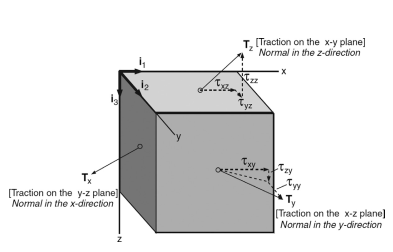

$$T_x = \begin{bmatrix}
\tau_{xx} \\
\tau_{yx} \\
\tau_{zx}
\end{bmatrix}, T_y = \begin{bmatrix}
\tau_{xy} \\
\tau_{yy} \\
\tau_{zy}
\end{bmatrix}, T_z = \begin{bmatrix}
\tau_{xz} \\
\tau_{yz} \\
\tau_{zz}
\end{bmatrix} $$

As componentes de tensão que atuam nesta superfície são denotadas $\tau_{xx}(\vec{x},t)$, $\tau_{yx}(\vec{x},t)$ e $\tau_{zx}(\vec{x},t)$. Nestes componentes, o segundo subscrito $x$ indica que a superfície é perpendicular ao eixo $x$. A tensão que atua em um plano é uma grandeza vetorial. Tensão em um ponto (Elemento de volume) é representado por um tensor de rank dois (Uma matriz cujas colunas contém vetores que se transforma como um tensor de segundo rank).

$$ [\tau] = 
\begin{bmatrix} 
\tau_{xx} & \tau_{xy}&\tau_{xz}\\
\tau_{yx} & \tau_{yy} & \tau_{yz}\\
\tau_{zx} & \tau_{zy} & \tau_{zz}
\end{bmatrix} = \tau_{ij}$$

Para um fluído não viscoso como a água. a força de tração é sempre orientada ao longo na normal (Não há efeito de cisalhamento). Assim, o tensor de tensão para um fluído não viscoso é dado como $\tau_{ij} = -p\delta_{ij}$;

$$ [\tau] = 
\begin{bmatrix} 
-p &0&0\\
0 & -p & 0\\
0& 0& -p
\end{bmatrix} $$

onde p é o escalar pressão.

### 2.2 Deslocamento de partícula e deformação

$$ \vec{u} =  
\begin{bmatrix} 
u_x(\vec{x}, t) \\
u_y(\vec{x}, t) \\
u_z(\vec{x}, t)
\end{bmatrix} $$

Em outras palavras, o vetor $\vec{u} = \vec{u}(\vec{x}, t)$ é a posição ocupada em um tempo $t$ por uma partícula que estava em $\vec{x}$ em $t=0$, e refere-se ao deslocamento da partícula de um estado de equilíbrio. Um sensor deve ser colocado capturar o moviemnto da partícula com o tempo. O deslocamento da partícula é função contínua com o tempo para todas as partículas do emio. As vezes é conveniente trabalhar com a velocidade da partícula

$$ \vec{v} =  
\begin{bmatrix} 
v_x(\vec{x}, t) \\
v_y(\vec{x}, t) \\
v_z(\vec{x}, t)
\end{bmatrix}  = \begin{bmatrix} 
\frac{\partial u_x}{\partial t} \\
\frac{\partial u_y}{\partial t} \\
\frac{\partial u_z}{\partial t} 
\end{bmatrix},$$

e a aceleração é dado por

$$ \vec{\gamma} =  
\begin{bmatrix} 
\gamma_x(\vec{x}, t) \\
\gamma_y(\vec{x}, t) \\
\gamma_z(\vec{x}, t)
\end{bmatrix} = \begin{bmatrix} 
\frac{\partial^2 u_x}{\partial t^2} \\
\frac{\partial^2 u_y}{\partial t^2}\\
\frac{\partial^2 u_z}{\partial t^2} 
\end{bmatrix}. $$

### 2.3 Elásticidade Linear ( Lei de Hooke )

Para um dado ponto $\vec{x}$ em um tempo $t$, a lei de hooke generalizada estabelece que a tensão é linearmente proporcional a deformação, ou estresse, nesse ponto. Matematicamente, podemos expressa-la em notação tensorial como

$$[\tau] = [c][e].$$

A constante de proporcionalidade, $c_{ijkl}$, é conhecida como módulo elástico ou constante de rigidez. Eles definem as propriedades elásticas do meio. Essas constantes constituem um tensor  de renk quatro. Componente da tensão pode ser expressa como uma combinação linar, como segue abaixo.

$$\tau_{ij} = \sum_{k, l} c_{ijkl}e_{kl}$$

#### 2.3.1 A questão da isotropia

Um material isotrópico é um material o qual as propriedades fisicas dele são indepedente da direção. Uma formação rochoso composta por pquenos critais aleatoriamente orientados pode ser tartada como isotrópica. Um matrial isotrópico reduz o número de módulos para dois. O tensor de rigidiz, nesse caso, pode ser escrito como

$$c_{ijkl} = \lambda(\vec{x})\delta_{ij}\delta_{kl} + \mu(\vec{x})(\delta_{ik}\delta_{jl} + \delta_{il}\delta_{jk}),$$

onde $\delta_{ij}$ é o delta de Kronecker.

Esse tensor tem a seguinte forma matricial

$$[C] = \begin{bmatrix}
\lambda + 2\mu & \lambda &  \lambda & 0& 0& 0\\
\lambda & \lambda + 2\mu &\lambda & 0 & 0 & 0\\
\lambda & \lambda &\lambda + 2\mu & 0 & 0 & 0\\
0 &0&0& \mu & 0 & 0\\
0 & 0 & 0 & 0 & \mu & 0\\
0 & 0 & 0 & 0 & 0 & \mu\\
\end{bmatrix}.$$

A isotropia do material reduz o número de módulos elásticos para duas constantes, $\mu$ e $\lambda$, conhecidas como parâmetros de Lamé. A cosntante $\mu$ refere-se a resistência para cisilhar. É uma grandeza positiva e têm unidade de tensão. A segunda constante, $\lambda$, não tem um significado físico simples, mas simplifica muito a lei de Hooke.

### 2.4 Equação do campo de deslocamento

A equação de movimento que governa a propagação da onda elásica é derivada da segunda lei de Newton : Força é igual ao produto da massa pela aceleração. A ccomponentes da força são derivadas das componentes da tensão agindo num elemento de volume representando a partícula $\vec{x}$ num dado tempo $t$, como ilustra a figura abaixo.

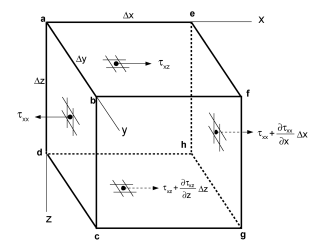

A componente da tensão da direção x na face a-b-c-d é $\tau_{xx}$ a qual é oposta a face e-f-g-h que é $\tau_{xx} + \frac{\partial \tau_{xx}}{\partial x}\Delta x$. A tensão nessa direção agindo nas duas faces é

$$\left(\tau_{xx} + \frac{\partial \tau_{xx}}{\partial x}\Delta x \right) - \tau_{xx} = \frac{\partial \tau_{xx}}{\partial x}.$$

A força resultado é a componente da tensão multiplicada pela área que é $\Delta y \Delta z$. Assim, a força é $\frac{\partial \tau_{xx}}{\partial x}\Delta x \Delta y \Delta z$. A componente da tensão da direção $x$ na face a-b-c-d é $\tau_{xy}$ a qual é oposta a face e-f-g-h que é $\tau_{xy} + \frac{\partial \tau_{xx}}{\partial y}\Delta y$. Assim, a força resultante é $\frac{\partial \tau_{xy}}{\partial x}\Delta x\Delta y\Delta z$. Usando a mesma lógica para a face a-b-f-e, temos que a força resultante é $\frac{\partial \tau_{xz}}{\partial z}\Delta x\Delta y\Delta z$. Assim, a componetente total da força da direção $x$ é

$$f_x = \left(\frac{\partial \tau_{xx}}{\partial x}+ \frac{\partial \tau_{xy}}{\partial y} + \frac{\partial \tau_{xz}}{\partial z}\right)\Delta x\Delta y\Delta z.$$

Substituindo a equação acima na segunda lei de Newton ($f_x = m\gamma_x$), onde $m = \rho\Delta x\Delta y\Delta z$ é a massa e $\gamma_x = \frac{\partial^2 u_x}{\partial t^2}$ na direção $x$, temos

$$\left(\frac{\partial \tau_{xx}}{\partial x}+ \frac{\partial \tau_{xy}}{\partial y} + \frac{\partial \tau_{xz}}{\partial z}\right) = \rho\frac{\partial^2 u_x}{\partial t^2}.$$

Fazendo considerações similares para as demais direções $y$ e $z$, temos um total de três equações de moviemento em $\vec{x}$ e em $t$.

$$
\begin{cases}
\left(\frac{\partial \tau_{xx}}{\partial x}+ \frac{\partial \tau_{xy}}{\partial y} + \frac{\partial \tau_{xz}}{\partial z}\right) = \rho\frac{\partial^2 u_x}{\partial t^2}\\
\left(\frac{\partial \tau_{yx}}{\partial x}+ \frac{\partial \tau_{yy}}{\partial y} + \frac{\partial \tau_{yz}}{\partial z}\right) = \rho\frac{\partial^2 u_y}{\partial t^2}\\
\left(\frac{\partial \tau_{zx}}{\partial x}+ \frac{\partial \tau_{zy}}{\partial y} + \frac{\partial \tau_{zz}}{\partial z}\right) = \rho\frac{\partial^2 u_z}{\partial t^2}\\
\end{cases}.
$$

Essas equações de moviemento são válidas para qualquer relação tensão-estresse, incluindo casos em que o meio não é inelástico e anisotropico. Mas, vamos limitar nossa análise parta casos elásticos e isotrópicos. Partindo da Lei de Hooke, podemos escrever nossas equações de moviemnto como um sistema de equações :

$$\rho(\vec{x})\frac{\partial^2 u_i(\vec{x}, t)}{\partial t^2} = \frac{\partial \tau_{ij}}{\partial x_j},$$

com $\tau_{ij} = c_{ijkl}(\vec{x})\frac{\partial u_k(\vec{x}, t)}{\partial x_l}$, onde $c_{ijkl} = \lambda(\vec{x})\delta_{ij}\delta_{kl} + \mu(\vec{x})(\delta_{ik}\delta_{jl} + \delta_{il}\delta_{jk})$.

Sendo assim, substituindo  lei de Hooke na equação de movimento, chegamos na equação geral de moviemento da elastodinâmica.

$$\boxed{\rho(\vec{x}) \frac{\partial ^2 u_i(\vec{x},t)}{\partial t^2} + \frac{\partial}{\partial x_j}\left[c_{ijkl}(\vec{x})\frac{\partial u_k(\vec{x},t)}{\partial x_l}\right] = 0}$$

#### 2.4.1 Equação de Movimento e Lei de Hooke Generalizada

Não importa o quão complicado seja um sistema de fonte sísmica, ele sempre pode ser representado por um força corporal. Vamos denotar pot $F_i$ essa força e a distribuição de deformação por $I_{ij}$. S e a terra está em descanso, a fonte está vazia, e a equação elástica não muda. Contudo, se a fonte profocar uma pertubação, então temos

$$\rho(\vec{x})\frac{\partial^2 u_i(\vec{x}, t)}{\partial t^2} = \frac{\partial \tau_{ij}}{\partial x_j} + F_i(\vec{x},t),$$

$$\tau_{ij} = c_{ijkl}(\vec{x})\frac{\partial u_k(\vec{x}, t)}{\partial x_l} - I_{ij}(\vec{x},t).$$

A equação acima é conhecida como lei de Hooke generalizada, devido a presença do termo fonte $I_{ij}$. Assim, a equação generalizada do campo de deslocamento fica

$$\boxed{\rho(\vec{x}) \frac{\partial ^2 u_i(\vec{x},t)}{\partial t^2} + \frac{\partial}{\partial x_j}\left[c_{ijkl}(\vec{x})\frac{\partial u_k(\vec{x},t)}{\partial x_l}\right] = F_i(\vec{x},t) + \frac{\partial I_{ij}(\vec{x},t)}{\partial x_j}}.$$

As variáveis relativas as posições da partícula no espçao e no tempo são introduzidas para enfatizar que os termos fontes podem ser distribuidos em todo volume ou localizadas em um ponto específico. Na sismologia de petróleo muitas fontes podem ser tratadas como uma fonte pontual.

#### 2.4.2 Ondas do tipo P e S

Outro aspecto importante da física envolvida na modelagem elástica é a teoria das ondas elásticas. Essa teoria descreve como as ondas mecânicas se propagam através de meios elásticos, como sólidos e líquidos. As ondas elásticas podem ser de diferentes tipos, como ondas longitudinais (ou ondas P) e ondas transversais (ou ondas S), e sua propagação e interação com materiais são governadas pelas propriedades elásticas do meio. Podemos chegar a essa relação resolvendo a equação pelo método da decomposição de Helmholtz.

Para isso, considere que para um meio homogênio, isotrópico e linear, no qual a equação do campo de deslocamento assume a seguinte forma

$$\rho(\vec{x}) \frac{\partial ^2 \vec{u}}{\partial t^2}  = (\lambda + \mu)\vec{\nabla}(\vec{\nabla} \vec{u}) + \mu \nabla^2\vec{u}.$$

A equação acima, também é conhecida como equação de Navier–Cauchy, exceto pelo termo fonte, ausente no momento. Note que podemos reescrever $\nabla^2 \vec{u} = \vec{\nabla}(\vec{\nabla} \cdot \vec{u}) - \vec{\nabla} \times (\vec{\nabla} \times \vec{u})$. Assim, chegamos na seguinte equação de movimento

$$\rho(\vec{x}) \frac{\partial ^2 \vec{u}}{\partial t^2}  = (\lambda + 2\mu)\vec{\nabla}(\vec{\nabla} \cdot \vec{u}) + \mu \vec{\nabla} \times (\vec{\nabla} \times \vec{u}).$$

A equação é complicada de resolver analiticamente em termos de $\vec{u}$, mas pode ser resolvida expressando o campo vetorial $\vec{u}$ como a soma de um escalar e um campo vetorial, $\chi$ e $\vec{\psi}$, respectivamente, tal que $\vec{u} = \vec{\nabla} \chi + \vec{\nabla} \times \vec{\psi}$, com $\vec{\nabla} \vec{\psi} = 0$. Esse método é, conhecido como decomposição de Helmholtz.

Fazendo essa substituição, chegamos na seguinte equação diferencial

$$(\lambda + 2\mu)\vec{\nabla}\left[\nabla^2 - \frac{\rho}{\lambda + \mu}\partial_t^2\right]\chi - \mu\vec{\nabla}\times \left[\vec{\nabla}\times\vec{\nabla} + \frac{\rho}{\mu}\partial_t^2\right]\vec{\psi} = 0,$$

que pode ser separada em duas equações distintas

$$\left(\nabla^2 - \frac{1}{V_p^2}\partial_t^2\right)\chi = 0,$$

$$\left(\vec{\nabla}\times\vec{\nabla}\times + \frac{1}{V_{s}^2}\partial_t^2\right)\vec{\psi} = 0,$$

com $V_p = \sqrt{\frac{\lambda + \mu}{\rho}}$ e $V_s = \sqrt{\frac{\mu}{\rho}}$.

A equação descreve ondas do tipo P, ou longitudinais, onde o movimento das partículas é paralelo a direção de propagação da onda. Já a equação descreve ondas do tipo S, ou tranversais, que só existem para meios cisilhantes, ou seja, $\mu \ne 0$, onde o moviemnto das partículas é perpendicula a direção de propagação da onda. Essa aspecto é importante, pois, diferentimente da modelagem acústica, onda criamos apenas um único campo de velocidade, na modelagem elástica precisamos computar duas campos de velocidades distintos. É importante notar também que $V_p \geq 1.15V_s$. A desmostração dessa propriedade pode ser encontrada no capítulo 2 do *Introduction to Petroleum Sismology*.

## 3. Implementação computacional

****

Como descrito anteriormente, os campo envolvidos na equação da onda elásticas são

* $\tau$ : Tensor de Tensão (Pa);
* $\vec{v}$ : Velocidade ($m/s$);
* $\vec{F}$ : Densidade da fonte de volume ($N/m^3$)
* $\vec{I}$ : Densidade da fonte de volume de tensão externa (Pa).

Usando essas quantidades, matematicamente, a propagação da onda elástica pode ser descrita via duas equações

$$\begin{cases} \frac{\partial v_i(\vec{x}, t)}{\partial t} - \sigma(\vec{x})\frac{\partial \tau_{ij}}{\partial x_j} = F_i(\vec{x}, t)\\
\frac{\partial \tau_{ij}(\vec{x}, t)}{\partial t} - c_{ijpq}(\vec{x})\frac{\partial v_q(\vec{x}, t)}{\partial x_p} = I_{ij}(\vec{x}, t)\end{cases}$$

onde $c_{ijpq}$ é o tensor de rigidez elástico e $\sigma$ é volume específico, ou $1/\rho$. O tensor de rigidez é simétrico, então $c_{ijpq} = c_{jipq} = c_{ijqp} = c_{ijqp}$ e $c_{ijpq} = c_{pqji}$.

Note que o índices $i$, $j$, $p$ e $q$ variam de 1 à 3. Então para um problema 2D, temos um total de 5 equações para resolver. Para solucionar essas equações, condições de contorno e inicias apropriadas são necessárias. As condições iniciais as quais a tensão e velocidade e suas derivadas são zeros antes da pertubação ;

$$\vec{v} = \partial_t \vec{v} = 0$$

$$\tau = \partial_t \tau = 0$$

As condições de borda para o problema de modelagem elástica são enssencialmentes determinadas por bordas de superfície livre; A interface ar-sólido na sísmica terrestre e da interface ar-água no caso da sísmcia marinha. Ao longo dessa seção, será assumido um limite plano de superfície livre. Então, as condições de contorno são

$$\tau_{xz}(x,y,z=0,t) = \tau_{yz}(x,y,z=0,t)  = \tau_{zz}(x,y,z=0,t)  = 0.$$

O objetivo aqui é apresenatar a solução numérica das equações de campo sob as condições de contorno e iniciais usando a técnica da diferenças finitas de grande escalonada de Mdariaga Virieux. O primeiro passo é discretizar o  modelo geológico e as quantidades que caracterizam o campo de onda, ou seja, a tensão e a velocidade. Aque, tanto o tempo quanto o espaço são discretizados da seguinte forma

### 3.1 Método da grade escalonada (Madariaga-Virieux staggered-grid finite-difference schem)

Na tecnica da grande escalonada, nem todas as quantidades físicas nas equações de campo são gradeadas na grade do ponto de referência. Algumas quantidades são definidas no ponto médio entre dois pontos da grande de referência. A figura baixo ilustra bem a configuração das quatidades físicas de interesse. Nota-se que as tensões normais, o volume específico e a rigidez estão localizados nos mesmos pontos. Duas questões se levantam : (1) Qual é a base para localizar algumas quantidades na grande de referência e outras fora dela ? e (2) porque escolhemos trabalahr com essa técnica ? O ojetivo de localizar algumas quantidades fora da grade de referência e produzir um esquema de diferenças finitas em que os operadores difernciais atuem apenas nas variáfveis do campo de onda e não sobre os parâmetros do meio. Lembre-se que o campo de onda é um função contínua no espçao e no tempo. Enquanto os parâmetros são geralmente funções descontínuas em relação as variáveis espaciais. A tecnica da grande escalonada nós permite evitar a diferenciação desses parâmetros sempre que possível.

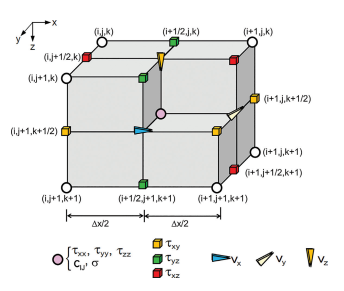

Usando o esquema representado na figura acima, podemos escrever os parâmetros do meio como

* $C_{IJ}(x,y,z) = C_{IJ}\left[\left(i+\frac{1}{2}\right)\Delta x, \left(j+\frac{1}{2}\right)\Delta y, \left(k+\frac{1}{2}\right)\Delta z \right] = [C_{IJ}]_{i+\frac{1}{2},j+\frac{1}{2},k+\frac{1}{2}};$

* $\sigma(x,y,z) = \sigma\left[\left(i+\frac{1}{2}\right)\Delta x, \left(j+\frac{1}{2}\right)\Delta y, \left(k+\frac{1}{2}\right)\Delta z \right] = [\sigma]_{i+\frac{1}{2},j+\frac{1}{2},k+\frac{1}{2}}.$

Para as variéveis do campo de onda temos

* $\tau_{pp}(x,y,z,t) = \tau_{pp}\left[\left(i+\frac{1}{2}\right)\Delta x, \left(j+\frac{1}{2}\right)\Delta y, \left(k+\frac{1}{2}\right)\Delta z , n\Delta t\right] = [\tau_{pp}]^n_{i+\frac{1}{2},j+\frac{1}{2},k+\frac{1}{2}};$

* $\tau_{xz}(x,y,z,t) = \tau_{xz}\left[i\Delta x, \left(j+\frac{1}{2}\right)\Delta y, k+\Delta z , n\Delta t\right] = [\tau_{xz}]^n_{i,j+\frac{1}{2},k};$

* $v_{x}(x,y,z,t) = v_x\left[i\Delta x, \left(j+\frac{1}{2}\right)\Delta y, \left(k+\frac{1}{2}\right)\Delta z , \left(n+\frac{1}{2}\right)\right] = [v_x]^{n+\frac{1}{2}}_{i,j+\frac{1}{2},k+\frac{1}{2}};$

* $v_{z}(x,y,z,t) =v_z\left[\left(i+\frac{1}{2}\right)\Delta x, \left(j+\frac{1}{2}\right)\Delta y, k\Delta z , n\Delta t\right] = [v_z]^{n+\frac{1}{2}}_{i+\frac{1}{2},j+\frac{1}{2},k}.$

onde $p = x, y, z$.

### 3.2 Aproximação de segunda ordem operadores diferenciais

Antes de apresentarmos as equações finais da técnica de grande escolonada, covém recordar algumas fórmulas básicas de cáclulos das derivadas de primeira ordem. As derivadas de primeira ordem de tecnica das diferenças finitas  são baseadas numa aproximação em série de taylor. As derividas podem ser aproxiamdas por um operador de sgunda, quarta ou ordem maiores. Para um fator $\alpha$ arbitrário, as derivadas de primeira ordem de uma função $g(x)$ podem ser aproximadas por uma fórmula de três pontos dada por *Abromowitz E Stegun (1964)* :

$$\frac{\partial g(x+\alpha\Delta x)}{\partial x} = \frac{1}{\Delta x}\left[ \left( \alpha - \frac{1}{2}\right)g(x - \Delta x) -  2\alpha g(x) + \left(\alpha + \frac{1}{2}\right)g(x + \Delta x)\right] + ...$$

A equação acima avaliada em $\alpha = 0$ fornece as derivadas na grade fe referência :

$$\frac{\partial g(x)}{\partial x} = \frac{1}{\Delta x}\left[ -\frac{1}{2}g(x - \Delta x) + \frac{1}{2}g(x + \Delta x)\right] + ...$$

Similarmente, quando avaliada em $\alpha = \frac{1}{2}$;

$$\frac{\partial g\left(x+\frac{1}{2}\Delta x\right)}{\partial x} \approx \frac{1}{\Delta x}\left[ -g(x - \Delta x) + g(x + \Delta x)\right] $$

A equação acima é o operador de segunda ordem para aproximar a derivada parcial de primeira ordem. A derivada temporal aqui será baseada nessa equação. Para as derivadas espaciais usaremos a aproximação de quarta ordem. Assim, temos que para $\alpha = \frac{1}{2}$

$$\frac{\partial g( x + \alpha\Delta x)}{\partial x} = \frac{1}{\Delta x}\left[ \frac{1}{12}(2\alpha^3 - 3\alpha^2 - \alpha + 1)g\left(x - 2\Delta x\right) + .. - \frac{1}{12}(2\alpha^3 - 3\alpha^2 - \alpha + 1)g\left(x + 2\Delta x\right)\right]$$

$$\frac{\partial g(x)}{\partial x} \approx \frac{1}{\Delta x}\left[ \frac{1}{24}g\left(x - \frac{3}{2}\Delta x\right) - \frac{9}{8}g\left(x - \frac{1}{2}\Delta x\right) + \frac{9}{8}g\left(x + \frac{1}{2}\Delta x\right) - \frac{1}{24}g\left(x + \frac{3}{2}\Delta x\right)\right].$$

### 3.3 Discretização das equações de movimento

Usando a fórmula para a aproximação de segunda ordem das derivadas parciais de primeira ordem, temos que as componentes do campo de vgelocidade $v_x$, $v_y$ e $v_z$ são

* $[v_x]^{n+\frac{1}{2}}_{i, j +\frac{1}{2},k+\frac{1}{2}} = [v_x]^{n-\frac{1}{2}}_{i, j +\frac{1}{2},k+\frac{1}{2}} + [\Delta t b_x(D_x\tau_{xx} + D_y\tau_{xy} + D_z\tau_{xz} + F_x)]^{n}_{i, j +\frac{1}{2},k+\frac{1}{2}};$

* $[v_y]^{n+\frac{1}{2}}_{i+\frac{1}{2}, j,k+\frac{1}{2}} = [v_y]^{n-\frac{1}{2}}_{i+\frac{1}{2}, j,k+\frac{1}{2}} + [\Delta t b_y(D_x\tau_{xy} + D_y\tau_{yy} + D_z\tau_{xz} + F_y)]^{n}_{i+\frac{1}{2}, j,k+\frac{1}{2}};$

* $[v_z]^{n+\frac{1}{2}}_{i+\frac{1}{2}, j +\frac{1}{2},k} = [v_z]^{n-\frac{1}{2}}_{i+\frac{1}{2}, j +\frac{1}{2},k} + [\Delta t b_z(D_x\tau_{xz} + D_y\tau_{yz} + D_z\tau_{zz} + F_z)]^{n}_{i+\frac{1}{2}, j +\frac{1}{2},k}.$

Sendo $b_x = \frac{1}{4}[\sigma_{i,j,k} + \sigma_{i-1,j,k}]$,  $b_y = \frac{1}{2}[\sigma_{i,j,k} + \sigma_{i,j-1,k}]$ e  $b_z = \frac{1}{2}[\sigma_{i,j,k} + \sigma_{i,j,k-1}]$. Os operadores $D_x$, $D_y$ e $D_z$ denotam a derivada de primeira oredem para $x,y$ e $z$. Por exemplo, a derivada espacial alo longo de $x$ é avaliada como :

$$D_xg_{i,j,k} \approx \frac{1}{\Delta x}\sum_{m}^{M}c^{M}_{m}(g_{i+m-\frac{1}{2},j,k} - g_{i-m+\frac{1}{2},j,k})$$

Note que  a computação de $v_x$. por exemplo, requer que o volume específico na grade $[i\Delta x, \left(j+\frac{1}{2}\right)\Delta y, k\Delta z]$. Infelizmente, o volume específico não é definido na grade para essa conbfiguração. A média aritmétrica do volume específico na grade $[\left(i-\frac{1}{2}\right)\Delta x, \left(j+\frac{1}{2}\right)\Delta y, k\Delta z]$ e $[\left(i+\frac{1}{2}\right)\Delta x, \left(j+\frac{1}{2}\right)\Delta y, k\Delta z]$ é usado obter o volume no ponto de interesse. Esse volume é denotado por $b_{x}$. Note que o operador diferencial sge somente nas variáveis do campo. Em seguinda, considere a diferenciação em grande escalonada na lei de hooke. A ideia de que os resultados de várias operações de diferenciação na grande escalonada são todos naturalmente centrados para coincidir com os pontos da grande e as quantidades associadas aos pontos conforme definido. Para elaborar este ponto, considere o cálculo de grande escalonada de $\tau_{xx}$,

$$[\tau_{xx}]^{n+1}_{i+\frac{1}{2}, j+\frac{1}{2}, k+\frac{1}{2}} = [\tau_{xx}]^{n}_{i+\frac{1}{2}, j+\frac{1}{2}, k+\frac{1}{2}} + \Delta t [C_{11}D_xv_x + C_{12}D_yv_y + C_{13}D_zv_z + C_{14}(D_zv_y + D_yv_z) + C_{15}(D_zv_x + D_xv_z)+ C_{16}(D_yv_x + D_xv_y) + I_{xx}]^{n+\frac{1}{2}}_{i+\frac{1}{2}, j+\frac{1}{2}, k+\frac{1}{2}}.$$

A computação dos termos diferenciais de $\tau_{xx}$ associados com $C_{14}$, $C_{15}$ e $C_{16}$ requer os valores da velocidade da partículas na grande que infelizmente não está definido. Isso pode ser verificado abaixo.

$$[D_xv_y]^{n+\frac{1}{2}}_{i+\frac{1}{2}, j+\frac{1}{2}, k+\frac{1}{2}} \approx \frac{1}{\Delta x}\sum_{m}^{M}c^{M}_{m}\left([v_y]^{n+\frac{1}{2}}_{i+m, j+\frac{1}{2}, k+\frac{1}{2}} - [v_y]^{n+\frac{1}{2}}_{i-m+1, j+\frac{1}{2}, k+\frac{1}{2}}\right)$$

$$ [C] = \begin{bmatrix}
C_{11} & C_{12} &  C_{13}& 0& 0& 0\\
C_{21} & C_{22} &C_{23}& 0 & 0 & 0\\
C_{31} & C_{32} &C_{33} & 0 & 0 & 0\\
0 &0&0& C_{44} & 0 & 0\\
0 & 0 & 0 & 0 & C_{55}& 0\\
0 & 0 & 0 & 0 & 0 & C_{66}\\
\end{bmatrix}.$$

Para computar $[D_xv_y]$ é necessário tomr valortes de $v_y$ que não estão definidos na grade, o que implicaria que precisamos interpolar para criar informação onde não temos. Se assurmirmos que o meio tem simetria ortorrômbica (Nove constantes elásticas), os termos que precisam de interpolação são eliminados e assim as componentes dos campos de tensão são definidas como

* $[\tau_{xx}]^{n+1}_{i+\frac{1}{2}, j+\frac{1}{2}, k+\frac{1}{2}} = [\tau_{xx}]^{n}_{i+\frac{1}{2}, j+\frac{1}{2}, k+\frac{1}{2}} + \Delta t [C_{11}D_xv_x + C_{12}D_yv_y + C_{13}D_zv_z + I_{xx}]^{n+\frac{1}{2}}_{i+\frac{1}{2}, j+\frac{1}{2}, k+\frac{1}{2}};$

* $[\tau_{yy}]^{n+1}_{i+\frac{1}{2}, j+\frac{1}{2}, k+\frac{1}{2}} = [\tau_{yy}]^{n}_{i+\frac{1}{2}, j+\frac{1}{2}, k+\frac{1}{2}} + \Delta t [C_{21}D_xv_x + C_{22}D_yv_y + C_{23}D_zv_z + I_{yy}]^{n+\frac{1}{2}}_{i+\frac{1}{2}, j+\frac{1}{2}, k+\frac{1}{2}};$

* $[\tau_{zz}]^{n+1}_{i+\frac{1}{2}, j+\frac{1}{2}, k+\frac{1}{2}} = [\tau_{zz}]^{n}_{i+\frac{1}{2}, j+\frac{1}{2}, k+\frac{1}{2}} + \Delta t [C_{31}D_xv_x + C_{32}D_yv_y + C_{33}D_zv_z + I_{zz}]^{n+\frac{1}{2}}_{i+\frac{1}{2}, j+\frac{1}{2}, k+\frac{1}{2}};$

* $[\tau_{yz}]^{n+1}_{i+\frac{1}{2}, j, k} = [\tau_{yz}]^{n}_{i+\frac{1}{2}, j, k} + \Delta t [\hat{C}_{44}(D_zv_y + D_yv_z)  + I_{yz}]^{n+\frac{1}{2}}_{i+\frac{1}{2}, j, k};$

* $[\tau_{xz}]^{n+1}_{i, j+\frac{1}{2}, k} = [\tau_{xz}]^{n}_{i, j+\frac{1}{2}, k} + \Delta t [\hat{C}_{55}(D_zv_x + D_xv_z)  + I_{xz}]^{n+\frac{1}{2}}_{i, j+\frac{1}{2}, k};$

* $[\tau_{xy}]^{n+1}_{i, j,k+\frac{1}{2}} = [\tau_{xy}]^{n}_{i, j, k+\frac{1}{2}} + \Delta t [\hat{C}_{55}(D_yv_x + D_xv_y)  + I_{xy}]^{n+\frac{1}{2}}_{i, j, k+\frac{1}{2}}.$

onde 

$$\hat{C}_{44} = \left[\frac{1}{4}\left(\frac{1}{[C_{44}]_{i,j,k}} + \frac{1}{[C_{44}]_{i,j-1,k}} + \frac{1}{[C_{44}]_{i,j,k-1}} + \frac{1}{[C_{44}]_{i,j-1,k-1}}\right)\right],$$

$$\hat{C}_{55} = \left[\frac{1}{4}\left(\frac{1}{[C_{55}]_{i,j,k}} + \frac{1}{[C_{55}]_{i-1,j,k}} + \frac{1}{[C_{55}]_{i,j,k-1}}+ \frac{1}{[C_{55}]_{i-1,j,k-1}}\right)\right],$$

$$\hat{C}_{66} = \left[\frac{1}{4}\left(\frac{1}{[C_{66}]_{i,j,k}} + \frac{1}{[C_{66}]_{i-1,j,k}} + \frac{1}{[C_{66}]_{i,j-1,k}} + \frac{1}{[C_{66}]_{i-1,j-1,k}}\right)\right].$$

Novamente usamos médias aritmétricas nas equações de $\hat{C}_{44}$ até $\hat{C}_{66}$ para acomodar o fato de que as constantes de rigidez estão localizadas nos pontos médios da grande de referência. Em resumo as equações das velocidades até os coeficientes são as soluções de diferenças finitas ecolonadas de *Madariaga - Virieux* para meios ortorrômbicos (Incluindo meios isotrópicos) para a configuração exposta na figura.

#### 3.3.1 Critério de Estabilidade numérica

Para a técnica de grade escalonada de *Madariaga - Virieux* o critério de estababilidade para evitar a dispersão numérica é dada pela equação abaixo

$$\frac{V_{p, max} \Delta t}{\Delta x} \leq \frac{1}{\sum_{m}^{M} |c^{(M)}_{m}|}$$

#### 3.3.2 Modelo 2D homogêneo e isotrópico

In [3]:
def ricker_pulse(f_corte, t):
    
    f_c = f_corte/(3*np.sqrt(np.pi))
    t_0 = (2*np.sqrt(np.pi))/f_corte
    t_d = t - t_0
    
    src = -(2*np.pi**3*(f_c*t_d)**2 - 1)*np.exp(-(np.pi**3*(f_c*t_d)**2))
    return src

In [50]:
# Discretização espacial
dx = 5
dz = dx
nx = 400
nz = 400
# Posição xz da fonte
ixs = 200
izs = 200
# Posição xz do receptor
izr = 150
ixr = 150
# Discretização temporal
nt = 800 # Nt*dt is the time duration of the propagation
isoType = 4 # type of source signature
dt = 0.5e-3  # sampling period in time (seconds)
snap1 = 50  # time of the first snapshot = snap1*dt
snapRate = 50  # time between snapshots = snapRate*dt
f_corte = 90 # frequência de corte

# Parâmetros do meio homogêneo
rho = 2.2
cp = 2500
cs = 1300
bb = dt / dx * (1.0 / rho)
rlamu = cp * cp * rho * dt / dx
rmu = cs * cs * rho * dt / dx
rla = rlamu - (2.0 * rmu)

# Coeficiente da aproximação de segunda ordem para a derivada
g1 = -1.0 / 24.0
g2 = 9.0 / 8.0
soufac = dt / (dx * dx)

# Inicializando a grade
x  = np.arange(nx)
x  = x * dx # Coordenada x
z  = np.arange(nz)
z  = z * dz # Coordenada z

time = np.linspace(0 * dt, nt * dt, nt)

In [51]:
source = ricker_pulse(f_corte, time)

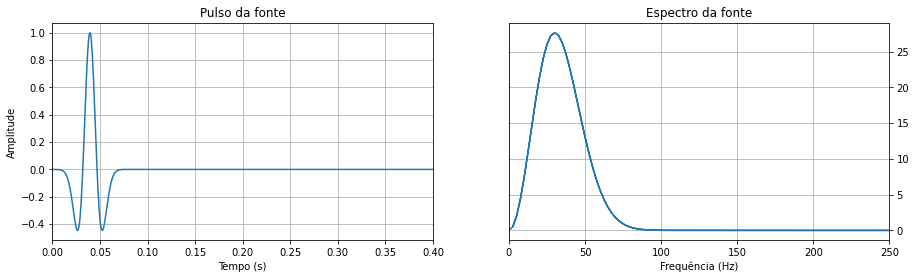

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].plot(time, source) # plot source time function
ax[0].set_title('Pulso da fonte')
ax[0].set_xlim(time[0], time[-1])
ax[0].set_xlabel('Tempo (s)')
ax[0].set_ylabel('Amplitude')
ax[0].yaxis.tick_left()
ax[0].yaxis.set_label_position("left")
ax[0].grid(True) 

spec = np.fft.fft(source) # source time function in frequency domain
freq = np.fft.fftfreq(spec.size, d = dt) # time domain to frequency domain
ax[1].plot(np.abs(freq), np.abs(spec)) # plot frequency and amplitude
ax[1].set_xlim(0, 250) # only display frequency from 0 to 250 Hz
ax[1].set_title('Espectro da fonte')
ax[1].set_xlabel('Frequência (Hz)')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].grid(True) 
plt.show()

In [53]:
txxrec = np.zeros(nt)
vx = np.zeros((nz, nx))
vz = np.zeros((nz, nx))
txx = np.zeros((nz, nx))
tzz = np.zeros((nz, nx))
txz = np.zeros((nz, nx))

snapTimes = np.arange(snap1, nt, snapRate)

pSnap = np.zeros((nz, nx, len(snapTimes)))
vxSnap = np.zeros((nz, nx, len(snapTimes)))
vzSnap = np.zeros((nz, nx, len(snapTimes)))

# Create meshgrid indices for vectorized operations
i, k = np.meshgrid(np.arange(2, nz - 2), np.arange(2, nx - 2), indexing='ij')

if (cp*dt)/dx <= 1/(abs(g1) + abs(g2)):
    print('Status : Stability criterium obeyed')

    with tqdm(total=nt) as progressing_load:
        for c1 in range(nt):
            
            #Atualizando o campo de velocidade

            vx[i, k] = vx[i, k] + bb * (
                g1 * (txx[i, k+1] - txx[i, k-2]) + g2 * (txx[i, k] - txx[i, k-1]) +
                g1 * (txz[i+2, k] - txz[i-1, k]) + g2 * (txz[i+1, k] - txz[i, k]))

            vz[i, k] = vz[i, k] + bb * (
                g1 * (txz[i, k+2] - txz[i, k-1]) + g2 * (txz[i, k+1] - txz[i, k]) +
                g1 * (tzz[i+1, k] - tzz[i-2, k]) + g2 * (tzz[i, k] - tzz[i-1, k]))

            if isoType == 4:
                adds = 0.5 * soufac * source[c1] / rho
                vx[izs, ixs] += adds
                vx[izs+1, ixs] +=  adds

            if isoType == 3:
                adds = 0.5 * soufac * source[c1] / rho
                vz[izs + 1, ixs - 1] += adds
                vz[izs + 1, ixs] +=  adds
                
            # Atauliazando o campo de tensão

            exx = g1 * (vx[i, k+2] - vx[i, k-1]) + g2 * (vx[i, k+1] - vx[i, k])
            ezz = g1 * (vz[i+2, k] - vz[i-1, k]) + g2 * (vz[i+1, k] - vz[i, k])
            exz = g1 * (vx[i+1, k] - vx[i-2, k]) + g2 * (vx[i, k] - vx[i-1, k]) + g1 * (vz[i, k+1] - vz[i, k-2]) + g2 * (vz[i, k] - vz[i, k-1])

            txx[i, k] = txx[i, k] + rlamu * exx + rla * ezz
            tzz[i, k] = tzz[i, k] + rla * exx + rlamu * ezz
            txz[i, k] = txz[i, k] + rmu * exz
            
            # Imprimindo a pertubação no modelo
        
            if isoType == 1:
                adds = soufac * source[c1] * 0.25
                txx[izs, ixs-1] += adds
                txx[izs, ixs] += adds
                txx[izs + 1, ixs - 1] += adds
                txx[izs + 1, ixs] += adds
                tzz[izs, ixs - 1] += adds
                tzz[izs, ixs] += adds
                tzz[izs + 1, ixs - 1] += adds
                tzz[izs + 1, ixs] += adds
            
            txxrec[c1] = txx[izr, ixr]
                
            # Guardando frames do campo de pressão e velocidade

            if c1 in snapTimes:
                snapIdx = np.where(snapTimes == c1)[0][0]
                pSnap[:, :, snapIdx] = 0.5 * (txx + tzz)
                vxSnap[:, :, snapIdx] = vx
                vzSnap[:, :, snapIdx] = vz

            progressing_load.update(1)
else:
    print('Status : Criterium stability not obeyed')

Status : Stability criterium obeyed


100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [01:55<00:00,  6.94it/s]


MovieWriter ffmpeg unavailable; using Pillow instead.


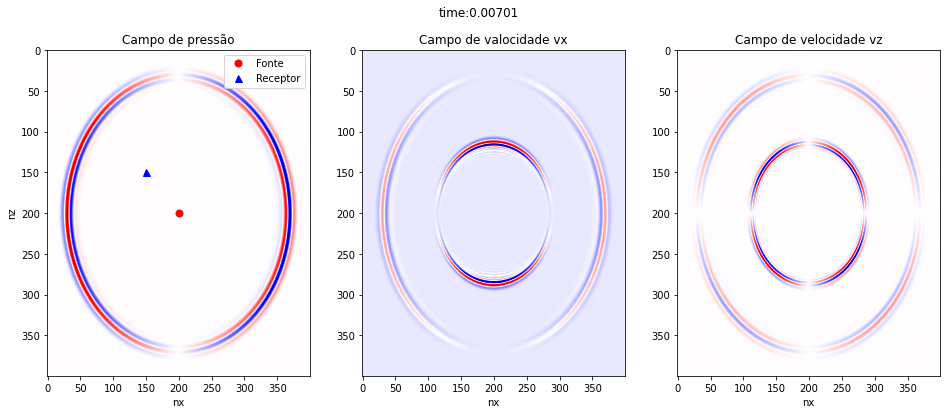

In [54]:
fig, ax = plt.subplots(1,3, figsize = (16, 6))

leg1, = ax[0].plot(ixs, izs, 'ro', markersize=7, color='red') # plot da posição da fonte
leg2, = ax[0].plot(ixr, izr, 'k^', markersize=7, color='blue')  
ax[0].legend((leg1, leg2), ('Fonte', 'Receptor'), loc='upper right', fontsize=10, numpoints=1)

ax[0].set_title('Campo de pressão')
ax[1].set_title('Campo de valocidade vx')
ax[2].set_title('Campo de velocidade vz')

ax[0].set_xlabel('nx')
ax[0].set_ylabel('nz')
ax[1].set_xlabel('nx')
ax[2].set_xlabel('nx')

def update(i):
    plt.suptitle(f'time:{round(time[i],5)}')
    ax[0].imshow(pSnap[:, :, i], aspect='auto', origin='upper', cmap='seismic', clim=(np.min(pSnap[:,:,7]), np.max(pSnap[:,:,7])))
    ax[1].imshow(vxSnap[:, :, i], aspect='auto', origin='upper', cmap='seismic', clim=(np.min(vxSnap[:,:,7]), np.max(vxSnap[:,:,7])))
    ax[2].imshow(vzSnap[:, :, i], aspect='auto', origin='upper', cmap='seismic', clim=(np.min(vzSnap[:,:,7]), np.max(vzSnap[:,:,7])))
    
ani = animation.FuncAnimation(fig, update, pSnap.shape[2] , interval = 130, repeat = True, cache_frame_data = False)
ani.save(f'ElasticWaveHomgeniusMedium.gif')
plt.show()

In [55]:
x, z, xi_x, xi_z  = smp.symbols('x z xi_x xi_z',real=True)

R = smp.sqrt((x - xi_x)**2 + (z - xi_z)**2)
gamma_x = (x - xi_x)/R
gamma_z = (z - xi_z)/R

fx1 = (3*gamma_x**2 - 1) / R**3
fx2 = (gamma_x**2) / R
fx3 = (gamma_x**2 - 1) / R

fz1 = (3*gamma_x*gamma_z) / R**3
fz2 = (gamma_x*gamma_z) / R

dfx1 = smp.diff(fx1, x)
dfx2 = smp.diff(fx2, x)
dfx3 = smp.diff(fx3, x)

dfz1 = smp.diff(fz1, z)
dfz2 = smp.diff(fz2, z)

In [56]:
dfx1 = smp.lambdify((x,z,xi_x,xi_z),dfx1)
dfx2 = smp.lambdify((x,z,xi_x,xi_z),dfx2)
dfx3 = smp.lambdify((x,z,xi_x,xi_z),dfx3)
dfz1 = smp.lambdify((x,z,xi_x,xi_z),dfz1)
dfz2 = smp.lambdify((x,z,xi_x,xi_z),dfz2)


# Inicializando a grade
xx  = np.arange(nx)
xx = xx * dx # Coordenada x
zz  = np.arange(nz)
zz  = zz * dz # Coordenada z

dfx1 = dfx1(x=xx[ixr],z=zz[izr],xi_x=xx[ixs],xi_z=zz[izs])
dfx2 = dfx2(x=xx[ixr],z=zz[izr],xi_x=xx[ixs],xi_z=zz[izs])
dfx3 = dfx3(x=xx[ixr],z=zz[izr],xi_x=xx[ixs],xi_z=zz[izs])
dfz1 = dfz1(x=xx[ixr],z=zz[izr],xi_x=xx[ixs],xi_z=zz[izs])
dfz2 = dfz2(x=xx[ixr],z=zz[izr],xi_x=xx[ixs],xi_z=zz[izs])

In [57]:
def delta_approx(x, epsilon=1e-4):
    delta = np.exp(-x**2 / (2 * epsilon**2)) / (epsilon * np.sqrt(2 * np.pi))
    return delta/np.max(delta)

def heaviside(x,y):
    if x - y >= 0 :
        return 1
    else:
        return 0

dGxx = np.zeros(nt)
dGzx = np.zeros(nt)
r = np.sqrt((xx[ixr]-xx[ixs])**2 + (zz[izr]-zz[izs])**2)

for i in range(nt):
    
    dGxx[i] = (
                (1/(4*np.pi*rho))*dfx1*(heaviside(time[i], r/cp) - heaviside(time[i], r/cs))*time[i]
            )
    dGzx[i] = (
                (1/(4*np.pi*rho))*dfz1*(heaviside(time[i], r/cp) - heaviside(time[i], r/cs))*time[i]
            )
    
dGxx += (1/(4*np.pi*rho*cp**2))*dfx2*delta_approx(time-r/cp) - (1/(4*np.pi*rho*cs**2))*dfx3*delta_approx(time-r/cs)
dGzx += (1/(4*np.pi*rho*cp**2))*dfz2*delta_approx(time-r/cp) - (1/(4*np.pi*rho*cs**2))*dfz2*delta_approx(time-r/cs)
    
Gc = rlamu * np.convolve(dGxx, source) + rla * np.convolve(dGzx, source)

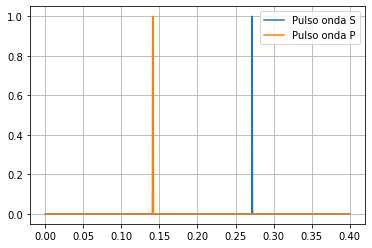

In [58]:
plt.plot(time, delta_approx(time-r/cs), label='Pulso onda S')
plt.plot(time,delta_approx(time-r/cp), label='Pulso onda P')
plt.legend()
plt.grid()
plt.show()

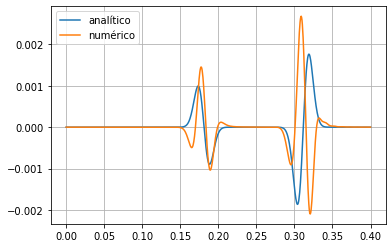

In [59]:
txxAna = Gc[0:nt]
plt.plot(time, txxAna*10000, label='analítico')
plt.plot(time, txxrec, label='numérico')
plt.legend()
plt.grid()
plt.show()

#### 3.3.1 Comparando com a solução analítica

Assim como fizemos para o caso acústico, vamos comparar nossa solução numérica com a solução analítica da das variáveis envolvidas e constar se nossa aproximação é satisfatória. Contudo, diferentimente do caso acústico, a solução analítica da onda elástica para um meio homogêneo, dado um fonte do tipo Pulso de Ricker, não é tão simples. E precisará que o autor tenha conhecimento sobre funções de Green.

Em primeiro lugar, não podemos solucionar de maneira analítica a equação geral da onda elástica, pois ela tem muitos parâmetros e termos cruzados, o que dificulta muito o desenvolvimento. O que vamos fazer, é usar as equações 5 e 6, obitidas pelo método de decomposição de Helmholtz, para separar os termos cruzados e resolver cada equação independentimente.

Agora, vamos impor que a solução seja dada pela convolução entre a função de Green e a função fonte.

$$\chi(\vec{x},t) = \int\int G_p(x,x',t,t')f(x',t')dx'dt'$$

$$\phi(\vec{x},t) = \int\int G_s(x,x',t,t')f(x',t')dx'dt'$$

O que precisamamos é : Dado um função fonte, nossa wavelet $f(x,t)$, achar a função de Green que obedece a equação da onda. Para nossa sorte, nossa wavelet, é uma fonte do tipo pontual, ou seja, de maneira geral podemos definir $f(x,t)$ como

$$f(x,t) = \delta(x-x_s)s(t),$$

onde $s(x,t)$ é nossa função Pulso de Ricker já definida em células anteriores. O delta facilita bastante os cálculos.

Jogando nossa solução da equação da onda temos,

### 3.4 Absorção do campo nas bordas usando PML (Perfectly Marched Layer)

Outro requisito importante da modelagem sísmica é a introdução de limites absorventes mo código de diferenças finitas para acomodar o fato que na maioria das aquisições é feita em áreas imensas, de modo que o campo de onda propagante que chega nos receptores não sofreu de reflexão laterais, por exemplo em aquisição em alto mar. Os limites de absorção consistem em uma faixa adiconal de pontos de grade em tonro do domíni computacional real capaz de absorver a entrada de ondas. Nesse contexto, temos duas técnicas que podem ser implementadas : a PML (Perfectly Marched Layer) e a condição de Cerjan. Para esta material usaremos a primeira opção, uma vez que a segunda já foi trabalhada em um notebook anterior.

A condição de Cerjan, ou também conhecida como condição limite de amortecimento, é criada cercando o modelo numérico com uma faixa de grade, onde os campos de tensão e velocidade são multiplicos por um fator $G(i)$ definido como

$$G(i) = e^{-\left[\frac{\alpha}{iabmax}(iabmax - i)\right]^2},$$

onde o $iabmax$ é o tamanho da grade de amortecimento e $\alpha$ é uma constante determinada por tentativa e erro. Para nossa implementação, usaremos $iabmax = 40$ e $\alpha = 0.2$.

#### 3.4.1 Modelo 2D homogênio, isotrópico e com condições atenuantes de borda

In [9]:
# Cerjan coefficients for boundary conditions
iabmax = 40
a0 = 0.2 / iabmax
eponge = np.zeros(iabmax + 2)
eponge[0:iabmax + 1] = np.exp(-(a0 * (iabmax - np.arange(iabmax + 1))) ** 2)

epongex = np.zeros((iabmax+2, nx+2))
epongez = np.zeros((nz+2, iabmax+2))

for i in range(nx):
    epongex[0:iabmax+1, i] = eponge[0:iabmax+1]


for i in range(nz):
    epongez[i,0:iabmax+1] = eponge[0:iabmax+1]

In [10]:
vx = np.zeros((nz, nx))
vz = np.zeros((nz, nx))
txx = np.zeros((nz, nx))
tzz = np.zeros((nz, nx))
txz = np.zeros((nz, nx))

snapTimes = np.arange(snap1, nt, snapRate)

pSnap = np.zeros((nz, nx, len(snapTimes)))
vxSnap = np.zeros((nz, nx, len(snapTimes)))
vzSnap = np.zeros((nz, nx, len(snapTimes)))

# Create meshgrid indices for vectorized operations
i, k = np.meshgrid(np.arange(2, nz - 2), np.arange(2, nx - 2), indexing='ij')

if (vp*dt)/dx <= 1/(abs(g1) + abs(g2)):
    print('Status : Stability critrerium obeyed')

    with tqdm(total=nt) as progressing_load:
        for c1 in range(nt):
            
            # Atualizando o campo de velocidade

            vx[i, k] = vx[i, k] + bb * (
                g1 * (txx[i + 1, k] - txx[i - 2, k]) + g2 * (txx[i, k] - txx[i - 1, k]) +
                g1 * (txz[i, k + 2] - txz[i, k - 1]) + g2 * (txz[i, k + 1] - txz[i, k]))

            vz[i, k] = vz[i, k] + bb * (
                g1 * (txz[i + 2, k] - txz[i - 1, k]) + g2 * (txz[i + 1, k] - txz[i, k]) +
                g1 * (tzz[i, k + 1] - tzz[i, k - 2]) + g2 * (tzz[i, k] - tzz[i, k - 1]))
            
            ia = np.arange(0, iabmax-1)
            ka = np.arange(0, iabmax-1)
                
            # Condição de absorção de borda (esquerda e direita)

            vx[0:nz-1, ia] = vx[0:nz-1, ia]*epongez[0:nz-1, ia]
            vz[0:nz-1, ia] = vz[0:nz-1, ia]*epongez[0:nz-1, ia]
            vx[0:nz-1, nx - ia - 1] = vx[0:nz-1, nx - ia - 1]*epongez[0:nz-1, ia]
            vz[0:nz-1, nx - ia - 1] = vz[0:nz-1, nx - ia - 1]*epongez[0:nz-1, ia]

            # Condição de absorção de borda (topo e base)

            vx[ka, 0:nx-1] = vx[ka, 0:nx-1]*epongex[ka, 0:nx-1]
            vz[ka , 0:nx-1] =  vz[ka, 0:nx-1]*epongex[ka, 0:nx-1]
            vx[nz - 1 - ka, 0:nx-1] = vx[nz - 1 - ka, 0:nx-1]*epongex[ka, 0:nx-1]
            vz[nz - ka -1, 0:nx-1] = vz[nz - ka - 1, 0:nx-1]*epongex[ka, 0:nx-1]

            if isoType == 4:
                adds = 0.5 * soufac * source[c1] / rho
                vx[izs, ixs] += adds
                vx[izs+1, ixs] +=  adds

            if isoType == 3:
                adds = 0.5 * soufac * source[c1] / rho
                vz[izs + 1, ixs - 1] += adds
                vz[izs + 1, ixs] +=  adds
                
            # Atauliazando o campo de tensão

            exx = g1 * (vx[i + 2, k] - vx[i - 1, k]) + g2 * (vx[i + 1, k] - vx[i, k])
            ezz = g1 * (vz[i, k + 2] - vz[i, k - 1]) + g2 * (vz[i, k + 1] - vz[i, k])
            exz = g1 * (vx[i, k + 1] - vx[i, k - 2]) + g2 * (vx[i, k] - vx[i, k - 1]) + g1 * (vz[i + 1, k] - vz[i - 2, k]) + g2 * (vz[i, k] - vz[i - 1, k])

            txx[i, k] = txx[i, k] + rlamu * exx + rla * ezz
            tzz[i, k] = tzz[i, k] + rla * exx + rlamu * ezz
            txz[i, k] = txz[i, k] + rmu * exz
            
            # Condição de absorção de borda (esquerda e direita)
            
            tzz[0:nz-1, ia]= tzz[0:nz-1, ia]*epongez[0:nz-1, ia]
            txx[0:nz-1, ia]= txx[0:nz-1, ia]*epongez[0:nz-1, ia]
            txz[0:nz-1, ia]= txz[0:nz-1, ia]*epongez[0:nz-1, ia]
            txx[0:nz-1, nx -1 -ia]=txx[0:nz-1, nx -1 -ia]*epongez[0:nz-1, ia]
            txz[0:nz-1, nx -1 -ia]=txz[0:nz-1, nx -1 -ia]*epongez[0:nz-1, ia]

            # Condição de absorção de borda (top e base)
            
            txx[ka,0:nx-1]= txx[ka, 0:nx-1]*epongex[ka, 0:nx-1]
            tzz[ka, 0:nx-1]= tzz[ka, 0:nx-1]*epongex[ka, 0:nx-1]
            txz[ka, 0:nx-1]= txz[ka, 0:nx-1]*epongex[ka, 0:nx-1]
            txx[nz - ka - 1, 0:nx-1]= txx[nz - ka - 1, 0:nx-1]*epongex[ka, 0:nx-1]
            tzz[nz - ka - 1, 0:nx-1]= tzz[nz - ka - 1, 0:nx-1]*epongex[ka, 0:nx-1]
            txz[nz - ka - 1, 0:nx-1]= txz[nz - ka - 1, 0:nx-1]*epongex[ka, 0:nx-1]
            
            # Imprimindo a pertubação no modelo
        
            if isoType == 1:
                adds = soufac * source[c1] * 0.25
                txx[izs, ixs-1] += adds
                txx[izs, ixs] += adds
                txx[izs + 1, ixs - 1] += adds
                txx[izs + 1, ixs] += adds
                tzz[izs, ixs - 1] += adds
                tzz[izs, ixs] += adds
                tzz[izs + 1, ixs - 1] += adds
                tzz[izs + 1, ixs] += adds
                
            # Guardando frames do campo de pressão e velocidade

            if c1 in snapTimes:
                snapIdx = np.where(snapTimes == c1)[0][0]
                pSnap[:, :, snapIdx] = 0.5 * (txx[0:nz, 0:nx] + tzz[0:nz, 0:nx])
                vxSnap[:, :, snapIdx] = vx[0:nz, 0:nx]
                vzSnap[:, :, snapIdx] = vz[0:nz, 0:nx]

            progressing_load.update(1)
else:
    print('Status : Criterium stability not obeyed')

Status : Stability critrerium obeyed


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:33<00:00,  6.52it/s]


MovieWriter ffmpeg unavailable; using Pillow instead.


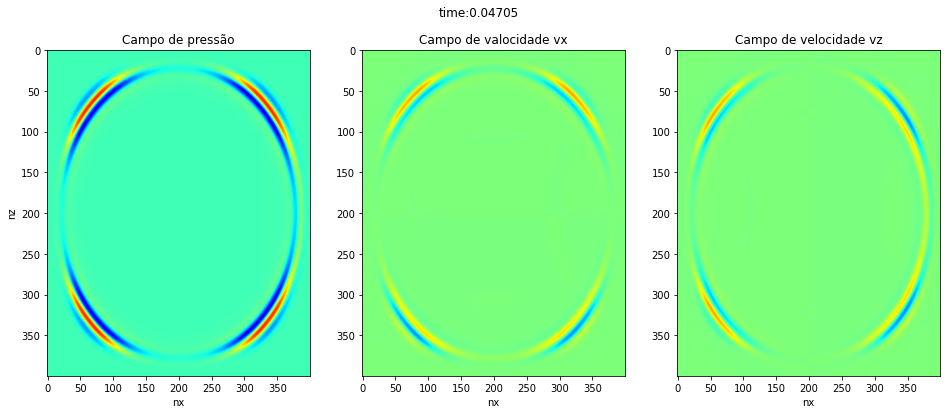

In [11]:
fig, ax = plt.subplots(1,3, figsize = (16, 6))

ax[0].set_title('Campo de pressão')
ax[1].set_title('Campo de valocidade vx')
ax[2].set_title('Campo de velocidade vz')


ax[0].set_xlabel('nx')
ax[0].set_ylabel('nz')
ax[1].set_xlabel('nx')
ax[2].set_xlabel('nx')

def update(i):
    plt.suptitle(f'time:{round(time[i],5)}')
    ax[0].imshow(pSnap[:, :, i], aspect='auto', origin='upper', cmap='jet', clim=(np.min(pSnap[:,:,60]), np.max(pSnap[:,:,60])))
    ax[1].imshow(vxSnap[:, :, i], aspect='auto', origin='upper', cmap='jet', clim=(np.min(vxSnap[:,:,40]), np.max(vxSnap[:,:,40])))
    ax[2].imshow(vzSnap[:, :, i], aspect='auto', origin='upper', cmap='jet', clim=(np.min(vzSnap[:,:,40]), np.max(vzSnap[:,:,40])))
    
ani = animation.FuncAnimation(fig, update,pSnap.shape[2] , interval = 130, repeat = True, cache_frame_data = False)
ani.save(f'ElasticWaveHomgeniusMediumcomabsorçãodeborda.gif')
plt.show()

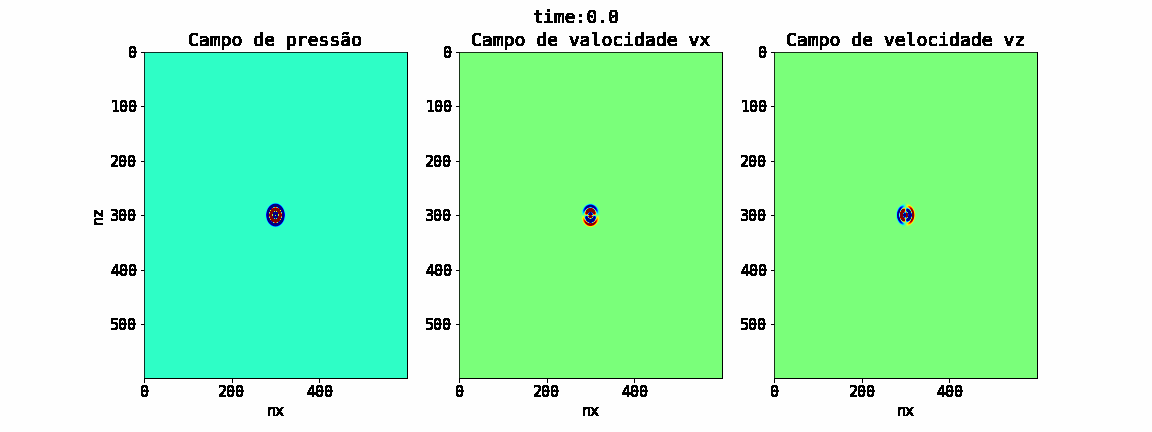

### 3.5 Condição de superfície livre

### 3.6 Modelagem 2D heterogênea do tipo fonte comum (Comum Shot Gather ) 

In [12]:
def model(nx,nz,vp,vs, rho):
    
    imagem = cv2.imread(r'C:\Users\Matheus\Downloads\subsurface.png')
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    image_red = imagem[:,:,0]  # extract red channel
    
    for i in range(0,nx):
        for j in range(0,nz):
            
            # assume vaccum in the violet caves
            # if image_red[j,i]==128, set vp = 0 m/s
            vp[j,i] = 10
            vs[j,i] = 8.6
            rho[j,i] = 1
            
            # if image_red[j,i]<50, set vp = 2000 m/s
            if(image_red[j,i]<112):
                vp[j,i] = 2000
                vs[j,i] = 1200
                rho[j,i] = 2.2
                
            # if image_red[j,i]>200, set vp = 3000 m/s
            if(image_red[j,i]>150):
                vp[j,i] = 2700
                vs[j,i] = 1700
                rho[j,i] = 3.0
                
    vp[:70,:] = 1200
    vs[:70,:] = 1000
    rho[:70,:] = 1.8
                
    return vp, vs, rho

In [13]:
# Discretização espacial
dx = 5
dz = dx
nx = 400
nz = 400

# Posição xz da fonte
ixs = 200
izs = 20

# Número de receptores
nrec = 400

# Posição xz do receptores
izr = 70
ixr = np.linspace(0,nx,nrec)

# Discretização temporal
nt = 2000 # Nt*dt is the time duration of the propagation
isoType = 1  # type of source signature
dt = 0.0008  # sampling period in time (seconds)
snap1 = 50  # time of the first snapshot = snap1*dt
snapRate = 25  # time between snapshots = snapRate*dt
dtdx = dt/dx
soufac = dt / (dx * dx)
f_corte = 48 # frequência de corte

# Coeficiente da aproximação de segunda ordem para a derivada
g1 = -1.0 / 24.0
g2 = 9.0 / 8.0

# Inicializando a grade
x    = np.arange(nx)
x    = x * dx    # Coordenada x
z    = np.arange(nz)
z    = z * dz   # Coordenada z

time = np.linspace(0 * dt, nt * dt, nt)

In [14]:
source = ricker_pulse(f_corte, time)

spec = np.fft.fft(source) # source time function in frequency domain
freq = np.fft.fftfreq(spec.size, d = dt)
num_onda = np.linspace(-(np.pi)/dx, (np.pi)/dx, nx)

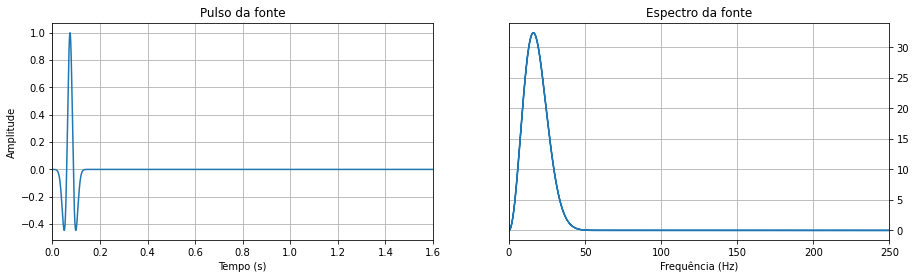

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].plot(time, source) # plot source time function
ax[0].set_title('Pulso da fonte')
ax[0].set_xlim(time[0], time[-1])
ax[0].set_xlabel('Tempo (s)')
ax[0].set_ylabel('Amplitude')
ax[0].yaxis.tick_left()
ax[0].yaxis.set_label_position("left")
ax[0].grid(True) 

ax[1].plot(np.abs(freq), np.abs(spec)) # plot frequency and amplitude
ax[1].set_xlim(0, 250) # only display frequency from 0 to 250 Hz
ax[1].set_title('Espectro da fonte')
ax[1].set_xlabel('Frequência (Hz)')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].grid(True) 
plt.show()

In [16]:
vp = np.zeros((nz,nx))
vs = np.zeros((nz,nx))
rho = np.zeros((nz,nx))

vp, vs, rho = model(nx,nz,vp,vs,rho)

mu = vs*vs*rho
lamb = vp*vp*rho - 2*mu

Plotando o modelo geológico criado

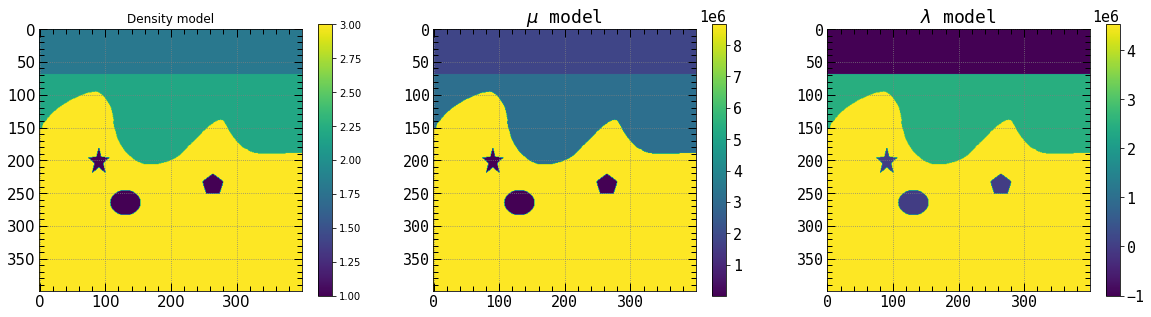

In [17]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.title('Density model')
plt.imshow(rho)
opt_plot()
plt.colorbar()
plt.subplot(1,3,2)
plt.title('$\mu$ model')
plt.imshow(mu)
plt.colorbar()
opt_plot()
plt.subplot(1,3,3)
plt.title('$\lambda$ model')
plt.imshow(lamb)
plt.colorbar()
opt_plot()
plt.show()

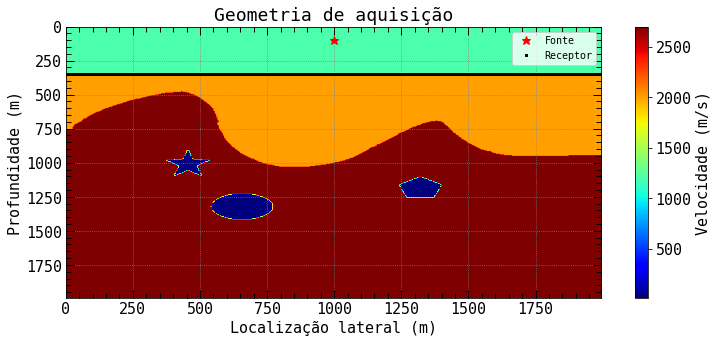

In [18]:
vmodel = np.copy(vp)

plt.figure(figsize=(12,5))
plt.title('Geometria de aquisição')
leg1, = plt.plot(ixs*dx, izs*dz, 'r*', markersize=9) # plot da posição da fonte
leg2, = plt.plot(ixr[0]*dx, izr*dz, 'ks', markersize=2)  
for i in range(1, nrec):
    plt.plot(ixr[i]*dx, izr*dz, 'ks', markersize=2)
mc = plt.imshow(vmodel, extent=[x[0],x[nx-1],z[nz-1],z[0]], aspect='auto', origin='upper', cmap='jet')
plt.ylabel('Profundidade (m)')
plt.xlabel('Localização lateral (m)')
plt.legend((leg1, leg2), ('Fonte', 'Receptor'), loc='upper right', fontsize=10, numpoints=1)
plt.colorbar(mc, label='Velocidade (m/s)')
opt_plot()
plt.show()

In [19]:
# Cerjan coefficients for boundary conditions
iabmax = 60
a0 = 0.3 / iabmax
eponge = np.zeros(iabmax + 2)
eponge[0:iabmax + 1] = np.exp(-(a0 * (iabmax - np.arange(iabmax + 1))) ** 2)

epongex = np.zeros((iabmax+2, nx+2))
epongez = np.zeros((nz+2, iabmax+2))

for i in range(nx):
    epongex[0:iabmax+1, i] = eponge[0:iabmax+1]


for i in range(nz):
    epongez[i,0:iabmax+1] = eponge[0:iabmax+1]

In [20]:
# Elastic Modulos Matrix
C = np.zeros((6,6,nz,nx))

for i in range(6):
    for j in range(6):
        if i == j and i < 3:
            C[i,j,:,:] = lamb + 2*mu
        elif i == j and i>=3:
            C[i,j,:,:] = mu
        elif i == 0 and (j==1 or j==2):
            C[i,j,:,:] = lamb
        elif i == 1 and (j==0 or j==2):
            C[i,j,:,:] = lamb
        elif i == 2 and (j==0 or j==1):
            C[i,j,:,:] = lamb

In [21]:
bxx = np.zeros((nz,nx))
bzz = np.zeros((nz,nx))
C55 = np.zeros((nz,nx))

for i in range(1, nz):
    for k in range(1, nx):
        bzz[i,k] = 0.5 * (1./rho[i - 1, k] + 1./rho[i, k])
        bxx[i,k] = 0.5 * (1./rho[i, k - 1] + 1./rho[i, k])
        C55[i,k] = (0.25*(1./C[4,4,i,k] + 1./C[4,4,i-1,k] + 1./C[4,4,i,k] + 1./C[4,4,i,k-1]))**(-1)

In [51]:
topbc = 'free'

vx = np.zeros((nz, nx))
vz = np.zeros((nz, nx))
txx = np.zeros((nz, nx))
tzz = np.zeros((nz, nx))
txz = np.zeros((nz, nx))
sismogram = np.zeros((nt, nrec))

snapTimes = np.arange(snap1, nt, snapRate)

pSnap = np.zeros((nz, nx, len(snapTimes)))
vxSnap = np.zeros((nz, nx, len(snapTimes)))
vzSnap = np.zeros((nz, nx, len(snapTimes)))

# Create meshgrid indices for vectorized operations
i, k = np.meshgrid(np.arange(2, nz - 2), np.arange(2, nx - 2), indexing='ij')

if (np.max(vmodel)*dt)/dx <= 1./(abs(g1) + abs(g2)):
    print('Status : Stability critreriun accepted')

    with tqdm(total=nt) as progressing_load:
        for c1 in range(nt):

            vx[i, k] += dtdx * bxx[i, k] * (g1 * (txx[i + 1, k] - txx[i - 2, k]) +
                                      g2 * (txx[i, k] - txx[i - 1, k]) +
                                      g1 * (txz[i, k + 2] - txz[i, k - 1]) +
                                      g2 * (txz[i, k + 1] - txz[i, k]))

            vz[i, k] += dtdx * bzz[i, k] * (g1 * (txz[i + 2, k] - txz[i - 1, k]) +
                                      g2 * (txz[i + 1, k] - txz[i, k]) +
                                      g1 * (tzz[i, k + 1] - tzz[i, k - 2]) +
                                      g2 * (tzz[i, k] - tzz[i, k - 1]))

            ia = np.arange(0, iabmax-1)
            ka = np.arange(0, iabmax-1)
                
            # Condição de absorção de borda (esquerda e direita)
    
            vx[0:nz-1, ia] = vx[0:nz-1, ia]*epongez[0:nz-1, ia]
            vz[0:nz-1, ia] = vz[0:nz-1, ia]*epongez[0:nz-1, ia]
            vx[0:nz-1, nx - ia - 1] = vx[0:nz-1, nx - ia - 1]*epongez[0:nz-1, ia]
            vz[0:nz-1, nx - ia - 1] = vz[0:nz-1, nx - ia - 1]*epongez[0:nz-1, ia]

            # Condição de absorção de borda (topo e base)
            
            if topbc == 'abbc':
                vx[ka, 0:nx-1] = vx[ka, 0:nx-1]*epongex[ka, 0:nx-1]
                vz[ka, 0:nx-1] = vz[ka, 0:nx-1]*epongex[ka, 0:nx-1]
            vx[nz - 1 - ka, 0:nx-1] = vx[nz - 1 - ka, 0:nx-1]*epongex[ka, 0:nx-1]
            vz[nz - ka - 1, 0:nx-1] = vz[nz - ka - 1, 0:nx-1]*epongex[ka, 0:nx-1]


            if isoType == 4:
                adds = 0.5 * soufac * source[c1] / rho
                vx[izs, ixs] += adds
                vx[izs+1, ixs] +=  adds

            if isoType == 3:
                adds = 0.5 * soufac * source[c1] / rho
                vz[izs + 1, ixs - 1] += adds
                vz[izs + 1, ixs] +=  adds

            exx = g1 * (vx[i + 2, k] - vx[i - 1, k]) + g2 * (vx[i + 1, k] - vx[i, k])
            ezz = g1 * (vz[i, k + 2] - vz[i, k - 1]) + g2 * (vz[i, k + 1] - vz[i, k])
            exz = g1 * (vx[i, k + 1] - vx[i, k - 2]) + g2 * (vx[i, k] - vx[i, k - 1]) + g1 * (vz[i + 1, k] - vz[i - 2, k]) + g2 * (vz[i, k] - vz[i - 1, k])

            txx[i, k] += dtdx * (C[0,0,i,k] * exx +  C[0,2,i,k] * ezz)
            tzz[i, k] += dtdx * (C[2,0,i,k] * exx +  C[2,2,i,k] * ezz)
            txz[i, k] += dtdx * C55[i,k]*exz
            
            # Condição de absorção de borda (esquerda e direita)
            
            tzz[0:nz-1, ia]= tzz[0:nz-1, ia]*epongez[0:nz-1, ia]
            txx[0:nz-1, ia]= txx[0:nz-1, ia]*epongez[0:nz-1, ia]
            txz[0:nz-1, ia]= txz[0:nz-1, ia]*epongez[0:nz-1, ia]
            tzz[0:nz-1, nx -1 -ia]=tzz[0:nz-1, nx -1 -ia]*epongez[0:nz-1, ia]
            txx[0:nz-1, nx -1 -ia]=txx[0:nz-1, nx -1 -ia]*epongez[0:nz-1, ia]
            txz[0:nz-1, nx -1 -ia]=txz[0:nz-1, nx -1 -ia]*epongez[0:nz-1, ia]

            # Condição de absorção de borda (topo e base)
            if topbc == 'abbc':
                txx[ka,0:nx-1]= txx[ka, 0:nx-1]*epongex[ka, 0:nx-1]
                tzz[ka, 0:nx-1]= tzz[ka, 0:nx-1]*epongex[ka, 0:nx-1]
                txz[ka, 0:nx-1]= txz[ka, 0:nx-1]*epongex[ka, 0:nx-1]
            txx[nz - ka - 1, 0:nx-1]= txx[nz - ka - 1, 0:nx-1]*epongex[ka, 0:nx-1]
            tzz[nz - ka - 1, 0:nx-1]= tzz[nz - ka - 1, 0:nx-1]*epongex[ka, 0:nx-1]
            txz[nz - ka - 1, 0:nx-1]= txz[nz - ka - 1, 0:nx-1]*epongex[ka, 0:nx-1]

            if isoType == 1:
                adds = soufac * source[c1] * 0.25
                txx[izs, ixs-1] += adds
                txx[izs, ixs] += adds
                txx[izs + 1, ixs - 1] += adds
                txx[izs + 1, ixs] += adds
                tzz[izs, ixs - 1] += adds
                tzz[izs, ixs] += adds
                tzz[izs + 1, ixs - 1] += adds
                tzz[izs + 1, ixs] += adds

            if c1 in snapTimes:
                snapIdx = np.where(snapTimes == c1)[0][0]
                pSnap[:, :, snapIdx] = 0.5 * (txx + tzz)
                vxSnap[:, :, snapIdx] = vx
                vzSnap[:, :, snapIdx] = vz

            for ix in range(nrec-1):
                sismogram[c1, ix] = 0.5 * (txx[izr, int(ixr[ix])] + tzz[izr, int(ixr[ix])])
            progressing_load.update(1)
else:
    print('Status : Criterium stability recused')

NameError: name 'nrec' is not defined

Plotando o sismograma

In [23]:
fk_domain = np.fft.fftshift(np.fft.fft2(sismogram, norm='ortho'), axes=-1).real

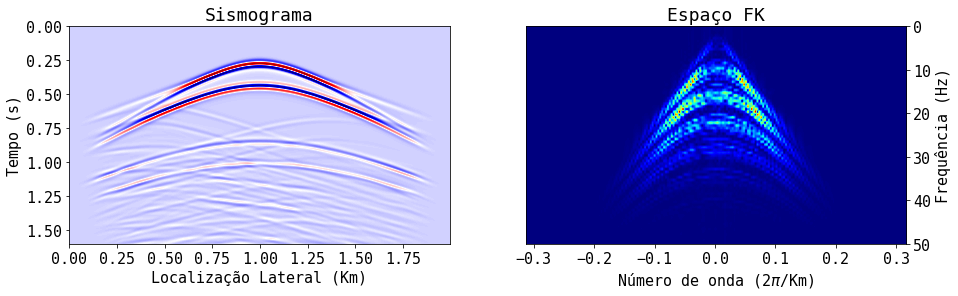

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].imshow(sismogram, extent=[x[0]/1000,x[nx-1]/1000,time[nt-1],time[0]],
           aspect='auto', origin='upper', cmap='seismic')
ax[0].set_title('Sismograma')
ax[0].set_ylabel('Tempo (s)')
ax[0].set_xlabel('Localização Lateral (Km)')
ax[0].yaxis.tick_left()
ax[0].yaxis.set_label_position("left")

ax[1].imshow(abs(fk_domain[0:80,100:300]),extent=[num_onda[100],num_onda[300],freq[80],freq[0]],
           aspect='auto', origin='upper', cmap='jet')
ax[1].set_title('Espaço FK')
ax[1].set_ylabel('Frequência (Hz)')
ax[1].set_xlabel('Número de onda (2$\pi$/Km)')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


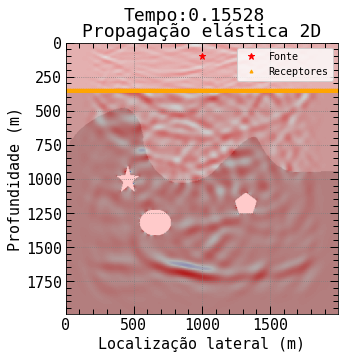

In [25]:
fig, ax = plt.subplots(1,figsize = (8, 5))

ax.set_title('Propagação elástica 2D')
leg1, = ax.plot(ixs*dx, izs*dz, 'r*', markersize=7) # plot da posição da fonte
leg2, = ax.plot(ixr[0]*dx, izr*dz, 'k^', markersize=3, color='orange')  
for i in range(1, nrec):
    ax.plot(ixr[i]*dx, izr*dz, 'k^', markersize=3, color='orange')
ax.set_ylabel('nz')
ax.set_xlabel('nx')
ax.legend((leg1, leg2), ('Fonte', 'Receptores'), loc='upper right', fontsize=10, numpoints=1)
ax.set_ylabel('Profundidade (m)')
ax.set_xlabel('Localização lateral (m)')

def update(i):
    plt.suptitle(f'Tempo:{round(time[i],5)}')
    ax.imshow(pSnap[:, :, i], extent=[x[0],x[nx-1],z[nz-1],z[0]],interpolation="nearest", 
              aspect='auto', origin='upper', cmap='seismic',clim=(np.min(pSnap[:,:,27]), np.max(pSnap[:,:,27])))
    ax.imshow(vmodel, extent=[x[0],x[nx-1],z[nz-1],z[0]], cmap='Greys', alpha = 0.3)
    
ani = animation.FuncAnimation(fig, update, pSnap.shape[2] , interval = 100, repeat = True, cache_frame_data = False)
opt_plot()
ani.save('ElasticWaveHeterogeneusMedium.gif')
plt.show()

## 4. Conclusão

****

Nossa implementação computacional foi satisfatória, e apesar dos modelos aqui compilados serem simples, o mesmo código pode ser usado para modelos geológicos 2D mais robostus, com dimensões maiores. É interessante notar que esse tipo de modelagem é custosa, e por isso procura-se usar operações `arrays` ao invés de laços de repetições do tipo `for`. Outra abordagem é usar uma linguagem mais otimizada para lidar com simulação numérica, como por exemplo: Linguagem Julia. Aqui está o link para a versão em Julia dos códigos presentes neste notebook []{}, []{}.

A modelagem elástica é preferida em muitos casos porque oferece uma representação mais completa e realista do comportamento dos materiais. Ela leva em conta não apenas as variações na pressão do meio, como na modelagem acústica, mas também considera a deformação do material. Isso permite uma representação mais precisa das propriedades mecânicas do meio, o que pode ser crucial em aplicações onde a deformação do material é significativa, como em levadamento de dados sísmicos do tipo OBN (Ocean Bottom Nodes), onde os receptores são dispostos no leito marinho. Contudo, sua presição também é sua maior desvantagem, pois o número grande parâmetros que precisam ser computados, traz um custo computacional imenso para essa abordagem.

## Referências

****

* **[1]** *Basic Principles of Wave Propagation, Gerard T. Schuster, 2011.* 

* **[2]**

* **[3]**